In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

In [ ]:
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False

In [ ]:
!wget "https://media.istockphoto.com/id/2166425804/photo/amazing-mountain-landscape-at-sunrise-silhouettes-of-the-carpathian-mountains-range-sky.webp?s=2048x2048&w=is&k=20&c=de5Eb77o2O7sVjJnIdoVOQtXS5zKAJFajhM54sGjQwE="
!wget "https://media.istockphoto.com/id/508628776/photo/sunset-over-kandariya-mahadeva-temple.webp?s=2048x2048&w=is&k=20&c=bfVX4nRr169bamT8x2VrPgjQYzS6y3D4Y9kGvoLiAS0="

content_img_path = "/content/amazing-mountain-landscape-at-sunrise-silhouettes-of-the-carpathian-mountains-range-sky.webp?s=2048x2048&w=is&k=20&c=de5Eb77o2O7sVjJnIdoVOQtXS5zKAJFajhM54sGjQwE="
style_img_path = "/content/sunset-over-kandariya-mahadeva-temple.webp?s=2048x2048&w=is&k=20&c=bfVX4nRr169bamT8x2VrPgjQYzS6y3D4Y9kGvoLiAS0="

--2025-06-30 22:19:06--  https://media.istockphoto.com/id/2166425804/photo/amazing-mountain-landscape-at-sunrise-silhouettes-of-the-carpathian-mountains-range-sky.webp?s=2048x2048&w=is&k=20&c=de5Eb77o2O7sVjJnIdoVOQtXS5zKAJFajhM54sGjQwE=
Resolving media.istockphoto.com (media.istockphoto.com)... 3.163.165.72, 3.163.165.44, 3.163.165.18, ...
Connecting to media.istockphoto.com (media.istockphoto.com)|3.163.165.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42318 (41K) [image/webp]
Saving to: ‘amazing-mountain-landscape-at-sunrise-silhouettes-of-the-carpathian-mountains-range-sky.webp?s=2048x2048&w=is&k=20&c=de5Eb77o2O7sVjJnIdoVOQtXS5zKAJFajhM54sGjQwE=.2’

amazing-mountain-la 100%[===================>]  41.33K  --.-KB/s    in 0.006s  

2025-06-30 22:19:06 (6.53 MB/s) - ‘amazing-mountain-landscape-at-sunrise-silhouettes-of-the-carpathian-mountains-range-sky.webp?s=2048x2048&w=is&k=20&c=de5Eb77o2O7sVjJnIdoVOQtXS5zKAJFajhM54sGjQwE=.2’ saved [42318/42318]

--2025

Content Image


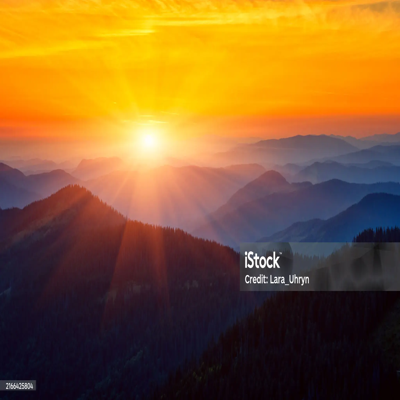

In [ ]:

content_image = Image.open(content_img_path)
content_image = content_image.resize((img_size, img_size))
print("Content Image")
content_image

Style Image


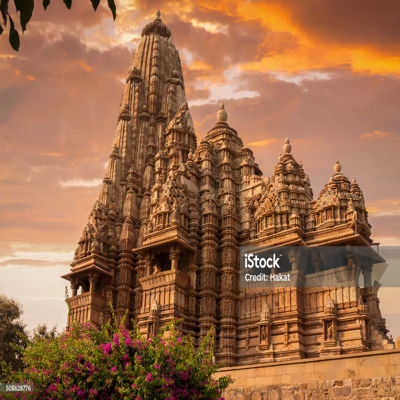

In [ ]:

content_image = Image.open(style_img_path)
content_image = content_image.resize((img_size, img_size))
print("Style Image")
content_image

In [ ]:

def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]


    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[_ , -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [_, -1,n_C])

    J_content = (1/(n_H * n_C * n_W * 4)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))


    return J_content

In [ ]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.linalg.matmul(A,A,transpose_b = True)

    return GA

In [ ]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    _, n_H, n_W, n_C = a_G.get_shape().as_list()


    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))

    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))


    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)


    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))

    return J_style_layer

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them

    Returns:
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [ ]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function

    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    J -- total cost as defined by the formula above.
    """

    J = alpha * J_content + beta * J_style


    return J

(1, 400, 400, 3)


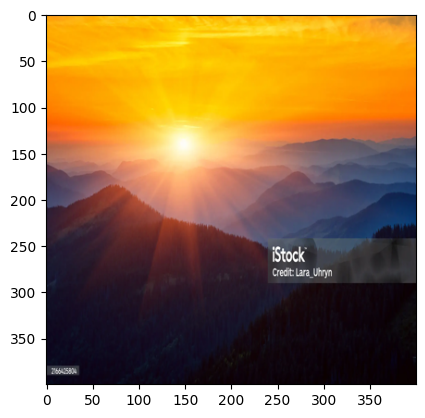

In [ ]:
content_image = np.array(Image.open(content_img_path).resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


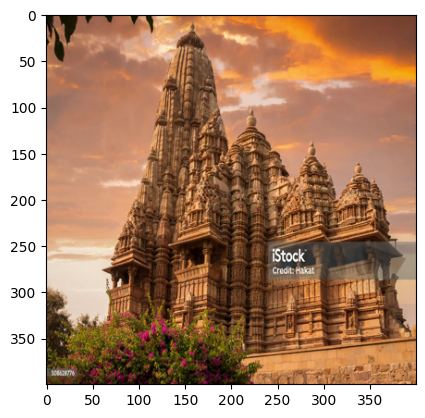

In [ ]:
style_image =  np.array(Image.open(style_img_path).resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


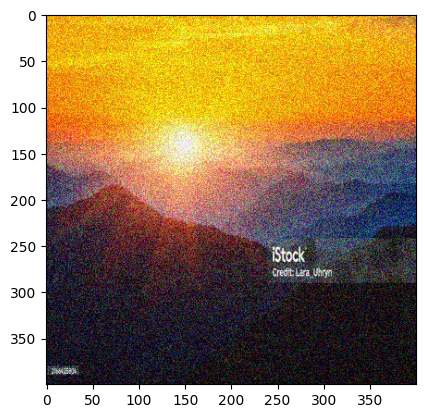

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [ ]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [ ]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(1, 400, 400, 3))
  warnings.warn(msg)


In [ ]:
# Assign the content image to be the input of the VGG model.
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [ ]:
# Assign the input of the model to be the "style" image
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [ ]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

#@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C



        # Compute a_G as the vgg_model_outputs for the current generated image

        a_G = vgg_model_outputs(generated_image)

        # Compute the style cost

        J_style = compute_style_cost(a_S, a_G)


        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style)



    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

In [ ]:
generated_image = tf.Variable(generated_image)

In [3]:
# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again
epochs = 2501
for i in range(epochs):
    train_step(generated_image)

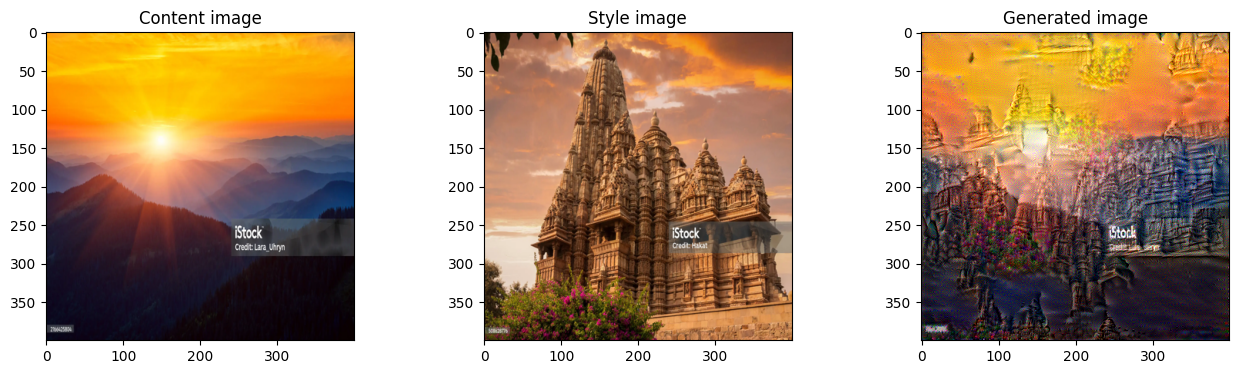

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()